In [1]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import pandas as pd
import os
from dask.distributed import Client

In [2]:
frames = []

In [3]:
client = Client()
client

<Client: scheduler='tcp://127.0.0.1:55059' processes=4 cores=12>

In [4]:
def align(arr):
    d = (arr[:,::2].mean(axis = 1) - arr[:,1::2].mean(axis = 1))
    for i in range(0,arr.shape[1], 2):
        arr[:,i] = arr[:,i] - d
    return arr

In [5]:
def remove_offset(arr):
    return arr - np.amin(arr, axis = 1, keepdims= True)

In [6]:
def barycenter(arr):
     return da.divide(da.sum(da.multiply(arr, np.array(list(range(0, arr.shape[1])))), axis = 1, keepdims = True), da.sum(arr, axis = 1, keepdims = True))

In [7]:
def mean_diff(arr):
    quarter = int((arr.shape[1])/ 4)
    outer = da.concatenate([frames[:,:quarter], frames[:,-(quarter):]], axis = 1)
    inner = frames[:,quarter: -(quarter)]
    return inner.mean(axis = 1, keepdims = True) - outer.mean(axis = 1, keepdims = True)

In [8]:
def symmetry(arr):
    sym = []
    for i in range(0, arr.shape[0]):
        b = ceil(arr[i, 37])
        if arr.shape[1] - b <= b:
            M = arr.shape[1] - b
        else:
            M = b
        sym.append(da.sum(da.flip(arr[i, :ceil(b)])[:M] - arr[i, ceil(b):M], axis = 1, keepdims= True))
    return da.concatenate(sym)
    

In [9]:
with open('E:\gits\pphast-analyzer\data\ECAL2-Thr_60\ECAL2-Thr_60.txt', 'r') as file:
    arr = np.genfromtxt(file, delimiter = ',', usecols = range(37), dtype = float)
    #arr = np.loadtxt(file, delimiter = ',', usecols = range(37), dtype = float)
    arr[:,5:] = align(arr[:,5:])
    arr[:,5:] = remove_offset(arr[:,5:])        

In [8]:
frames = da.from_array(arr, chunks = (1000000, 43))

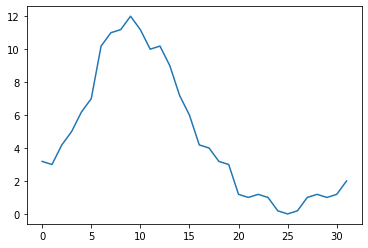

In [9]:
plt.plot(frames[0,5:])

In [127]:
%%time
bar = da.divide(da.sum(da.multiply(frames[:,5:], np.array(list(range(0, frames.shape[1]-5)))), axis = 1), da.sum(frames[:,5:], axis = 1))

Wall time: 82.5 ms


In [10]:
bary = barycenter(frames[:,5:])

In [11]:
frames = da.concatenate([frames, bary], axis = 1)

In [12]:
frames.shape

(3848300, 38)

In [ ]:
m_diff = mean_difference(frames[:,5:-1])

In [31]:
frames = da.concatenate([frames, m_diff], axis = 1)
frames.shape

dask.array<getitem, shape=(3848300, 32), dtype=float64, chunksize=(1000000, 32)>